In [20]:
import xarray as xr
import pandas as pd
import os
import pyproj
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import noaa_csl_funcs as ncf
from regrid_data import RegridInputs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Point data

In [49]:
base_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base' #where the data downloaded using data_download.py lives
bau_or_covid = 'COVID'
BCH = ncf.Base_CSL_Handler(base_path,bau_or_covid)
year = 2019
month = 1
sector = 'point_Industry' 
day_type = 'weekdy'
base_ds = BCH.load_fullday_nc(sector,year,month,day_type)
base_ds = base_ds.rename({'XLONG':'lon','XLAT':'lat'})
del base_ds.attrs['nc_fpath']
base_ds

<xarray.Dataset>
Dimensions:   (ROW: 191836, utc_hour: 24)
Coordinates:
    lon       (ROW) float32 -87.5 -91.68 -75.01 -88.27 ... -108.1 -108.1 -77.7
    lat       (ROW) float32 37.65 41.92 40.82 41.89 ... 39.4 39.4 39.4 37.66
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: ROW
Data variables: (12/87)
    ITYPE     (ROW) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0 1.0
    STKht     (ROW) float32 76.2 125.6 76.2 19.81 ... 6.096 4.572 1.524 9.144
    STKdiam   (ROW) float32 3.658 3.661 1.219 1.015 ... 0.61 0.152 0.201 nan
    STKtemp   (ROW) float32 433.1 427.6 754.3 533.2 ... 644.3 810.9 724.8 nan
    STKve     (ROW) float32 8.992 20.99 13.62 9.737 ... 3.048 0.03 6.706 nan
    STKflw    (ROW) float32 94.56 220.9 nan 7.881 7.968 ... nan 0.0006 nan nan
    ...        ...
    PM14      (utc_hour, ROW) float32 dask.array<chunksize=(12, 191836), meta=np.ndarray>
    PM15      (utc_hour, ROW) float32 dask.array<chunksize=(12, 191836), meta=np.ndarray>
    PM16      (utc_hour, ROW) float32 dask.array<chunksize=(12, 191836), meta=np.ndarray>
    PM17      (utc_hour, ROW) float32 dask.array<chunksize=(12, 191836), meta=np.ndarray>
    PM18      (utc_hour, ROW) float32 dask.array<chunksize=(12, 191836), meta=np.ndarray>
    PM19      (utc_hour, ROW) float32 dask.array<chunksize=(12, 191836), meta=np.ndarray>
Attributes:
    grid_type:  point
    sector_id:  Industry
    year:       2019
    month:      1
    day_type:   weekdy

In [33]:
regridded_ds = xr.open_dataset('/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/area_Industry/2019/Month01/weekdy/area_Industry_regridded.nc')
regridded_ds

<xarray.Dataset>
Dimensions:   (utc_hour: 24, lat: 390, lon: 790)
Coordinates:
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lat       (lat) float64 19.0 19.1 19.2 19.3 19.4 ... 57.6 57.7 57.8 57.9
  * lon       (lon) float64 -138.0 -137.9 -137.8 -137.7 ... -59.3 -59.2 -59.1
Data variables: (12/95)
    HC54      (utc_hour, lat, lon) float64 ...
    HC55      (utc_hour, lat, lon) float64 ...
    HC56      (utc_hour, lat, lon) float64 ...
    HC57      (utc_hour, lat, lon) float64 ...
    HC58      (utc_hour, lat, lon) float64 ...
    HC59      (utc_hour, lat, lon) float64 ...
    ...        ...
    PM14      (utc_hour, lat, lon) float64 ...
    PM15      (utc_hour, lat, lon) float64 ...
    PM16      (utc_hour, lat, lon) float64 ...
    PM17      (utc_hour, lat, lon) float64 ...
    PM18      (utc_hour, lat, lon) float64 ...
    PM19      (utc_hour, lat, lon) float64 ...
Attributes:
    grid_type:  area
    sector_id:  Industry
    year:       2019
    month:      1
    day_type:   weekdy
    nc_fpath:   /uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/...
    git_sha:    bc7d70102e5509ecec2799fff7032a45afb1c44f

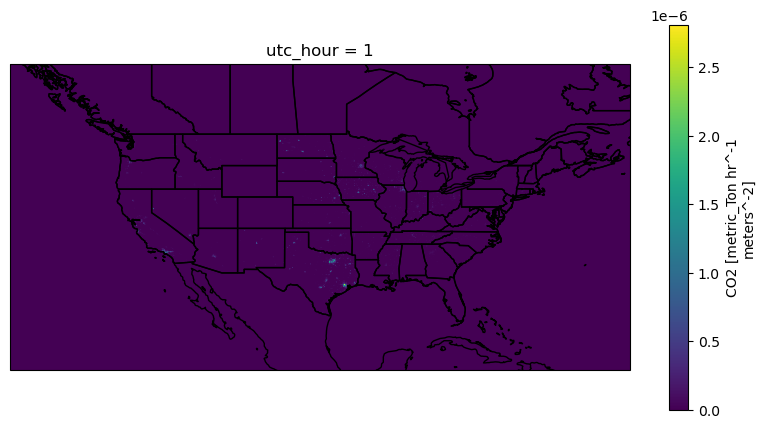

In [32]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection = proj)
#ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
regridded_ds.sel({'utc_hour':1})['CO2'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

# Post Regrid Data Handling

In [23]:
class Regridded_CSL_Handler:
    def __init__(self,regridded_path,bau_or_covid='COVID'):
        self.regridded_path = regridded_path
        self.sectors = self.get_sectors()
        self.bau_or_covid = bau_or_covid

    def get_sectors(self):
        '''Lists the sectors in the regridded data storage path'''

        sector_list = ncf.listdir_visible(self.regridded_path)
        sectors = {'area':[],'point':[]}
        for sector in sector_list:
            if 'area' in sector:
                sectors['area'].append(sector)
            elif 'point' in sector:
                sectors['point'].append(sector)
            else:
                raise ValueError(f"Unexpected sector type {sector}, not point or area.")
        return sectors

    def get_sector_subset_list(self,sector_subset):
        if sector_subset == 'all':
            sector_subset_list = []
            for k,v in self.sectors.items():
                sector_subset_list.extend(v)
            return sector_subset_list
        elif type(sector_subset)==str:
            return self.sectors[sector_subset]
        else:
            return sector_subset

    def get_days_in_range(self,dt1,dt2,day_types,sector_subset = 'all',add_path=True):
        '''Gets all filepaths to the day_type level that are within a datetime range
        
        Args:
        dt1 (datetime.date) : a date, datetime, etc to start the range (will only use year and month)
        dt2 (datetime.date) : a date, datetime, etc to end the range (will only use year and month)
        sectors (list) : list of sectors to include in the list
        day_types (list) : list of day types to include in the list
        add_path (bool, optional) : if true (default) it will add the regridded path to each element

        Returns:
        days_in_range (list) : list of paths to files that are within the date range and sector, day_types, etc. 
        '''

        dates_list = pd.date_range(dt1,dt2,freq = 'MS') #get a list of all the months between the dts
        sector_subset_list = self.get_sector_subset_list(sector_subset)
        days_in_range = []
        for date in dates_list:
            for sector in sector_subset_list:
                for day_type in day_types:
                    day_path = f'{sector}/{ncf.yr_to_yrstr(sector,date.year,self.bau_or_covid)}/{ncf.month_int_to_str(date.month)}/{day_type}'
                    if add_path:
                        days_in_range.append(os.path.join(self.regridded_path,day_path))
                    else:
                        days_in_range.append(day_path)
        return days_in_range
    
    def get_files_in_days(self,days_paths):
        files = []
        for day_path in days_paths:
            files.extend(ncf.listdir_visible(day_path,add_path=True))
        return files
    
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
RCH = Regridded_CSL_Handler(regridded_path)

dt1  = '2021-05'
dt2 = '2021-05'
days_paths = RCH.get_days_in_range(dt1,dt2,['weekdy'],sector_subset=['area_offroad'])
files = RCH.get_files_in_days(days_paths)
ds = xr.open_dataset(files[0])

In [51]:
ds = xr.open_dataset('/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/point_EGU/2019/Month01/weekdy/point_EGU.nc')
ds

<xarray.Dataset>
Dimensions:   (ROW: 191836, utc_hour: 24)
Coordinates:
    lon       (ROW) float32 ...
    lat       (ROW) float32 ...
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: ROW
Data variables: (12/87)
    ITYPE     (ROW) float32 ...
    STKht     (ROW) float32 ...
    STKdiam   (ROW) float32 ...
    STKtemp   (ROW) float32 ...
    STKve     (ROW) float32 ...
    STKflw    (ROW) float32 ...
    ...        ...
    PM14      (utc_hour, ROW) float32 ...
    PM15      (utc_hour, ROW) float32 ...
    PM16      (utc_hour, ROW) float32 ...
    PM17      (utc_hour, ROW) float32 ...
    PM18      (utc_hour, ROW) float32 ...
    PM19      (utc_hour, ROW) float32 ...
Attributes:
    grid_type:  point
    sector_id:  EGU
    year:       2019
    month:      1
    day_type:   weekdy
    git_sha:    5963a62a909302a9972a8223ca1609d608143562

KeyError: 'CO2'

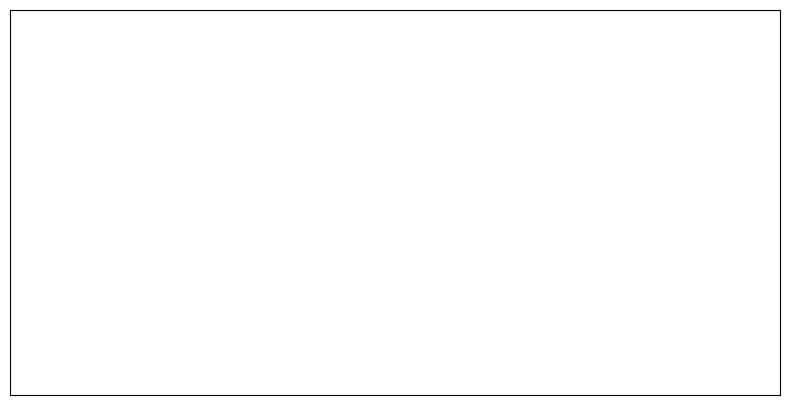

In [14]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection = proj)
#ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
ds['NOX'].sel({'utc_hour':1})['CO2'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

In [9]:
ds['CO2'].sum(dim='utc_hour')

<xarray.DataArray 'CO2' (lat: 390, lon: 790)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float64 19.0 19.1 19.2 19.3 19.4 ... 57.5 57.6 57.7 57.8 57.9
  * lon      (lon) float64 -138.0 -137.9 -137.8 -137.7 ... -59.3 -59.2 -59.1

In [7]:
# Can use this if you are looking at a "point" dataset

df = base_ds['CO2'][1].to_dataframe()
sub_df = df.loc[df['CO2']>100]

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
#ax.scatter(sub_df['XLONG'],sub_df['XLAT'],c=sub_df['CO2'])
ds
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

<xarray.Dataset>
Dimensions:   (utc_hour: 24, lat: 390, lon: 790)
Coordinates:
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lat       (lat) float64 19.0 19.1 19.2 19.3 19.4 ... 57.6 57.7 57.8 57.9
  * lon       (lon) float64 -138.0 -137.9 -137.8 -137.7 ... -59.3 -59.2 -59.1
Data variables: (12/95)
    HC54      (utc_hour, lat, lon) float64 ...
    HC55      (utc_hour, lat, lon) float64 ...
    HC56      (utc_hour, lat, lon) float64 ...
    HC57      (utc_hour, lat, lon) float64 ...
    HC58      (utc_hour, lat, lon) float64 ...
    HC59      (utc_hour, lat, lon) float64 ...
    ...        ...
    PM14      (utc_hour, lat, lon) float64 ...
    PM15      (utc_hour, lat, lon) float64 ...
    PM16      (utc_hour, lat, lon) float64 ...
    PM17      (utc_hour, lat, lon) float64 ...
    PM18      (utc_hour, lat, lon) float64 ...
    PM19      (utc_hour, lat, lon) float64 ...
Attributes:
    grid_type:  area
    sector_id:  AG
    year:       2019
    month:      1
    day_type:   weekdy
    nc_fpath:   /uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/...
    git_sha:    92fb5294dcd43b0f579cec9e7a92ad1e13b2036e

In [54]:
ds1 = xr.open_dataset(files[0])
ds2 = xr.open_dataset(files[1])

def preprocess(ds):
    ds = ds.assign_coords(sector = ds.attrs['sector_id'])
    ds = ds.expand_dims(dim='sector')
    return ds

ds1_sec = preprocess(ds1)
ds2_sec = preprocess(ds2)

#xr.open_mfdataset(files,concat_dim = 'sector',combine='nested',preprocess=preprocess)

In [59]:
ds_comb = xr.combine_by_coords([ds1_sec,ds2_sec],combine_attrs='override')

In [62]:
ds_comb.sum(dim='sector')

<xarray.Dataset>
Dimensions:   (utc_hour: 24, lat: 390, lon: 790)
Coordinates:
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lat       (lat) float64 19.0 19.1 19.2 19.3 19.4 ... 57.6 57.7 57.8 57.9
  * lon       (lon) float64 -138.0 -137.9 -137.8 -137.7 ... -59.3 -59.2 -59.1
Data variables: (12/80)
    CO        (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CO2       (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    HC01      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    HC02      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    HC03      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    HC04      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...        ...
    PM17      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PM18      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PM19      (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PM25-PRI  (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SO2       (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VOC       (utc_hour, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

: 

## Unit conversion

Ongoing work about unit conversion

In [ ]:
class CSLSpeciesDetails:
    def __init__(self,csv_fullpath):
        self.csv_fullpath = csv_fullpath
        self.df = self.load_details_csv()

    def load_details_csv(self,csv_fullpath = None):
        if csv_fullpath is None:
            csv_fullpath = self.csv_fullpath
        
        species_details_df = pd.read_csv(csv_fullpath,header = 17)
        return species_details_df
    
    def make_mw_dict(self,saprc_version = 'either'):
        mw_dict = {}
        if saprc_version == 'either':
            for _,row in self.df.iterrows():
                species = row['NC_name']
                mw_dict[species] = {}
                if row['Known_MW'] == row['Known_MW']: #known mw is not a nan, so use this first
                    mw_dict[species]['mw(g/mol)']=row['Known_MW']
                    mw_dict[species]['mw_source'] ='Known_MW'
                elif row['SAPRC99_MW'] == row['SAPRC99_MW']: #use saprc99 first
                    mw_dict[species]['mw(g/mol)'] = row['SAPRC99_MW']
                    mw_dict[species]['mw_source'] = 'SAPRC99_MW'        
                elif row['SAPRC22_MW'] == row['SAPRC22_MW']: #use saprc22 next
                    mw_dict[species]['mw(g/mol)'] = row['SAPRC22_MW']
                    mw_dict[species]['mw_source'] = 'SAPRC22_MW'      
                else:
                    mw_dict[species]['mw(g/mol)'] = np.nan
                    mw_dict[species]['mw_source'] = np.nan   
        else:
            raise ValueError('Havent made anything other that "either"')  #could do SAPRC22 only, 99 only, mixed etc TODO
        return mw_dict
    
csd = CSLSpeciesDetails('/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/NOAA_CSL_species.csv')
csl_mw_dict = csd.make_mw_dict()


In [ ]:
regridded_ds[list(regridded_ds.data_vars.keys())[0]].attrs['units']

In [ ]:
for species in list(regridded_ds.data_vars.keys()):
    species_units_list = unit_converter.unit_finder(regridded_ds[species])
    if ('metric_Ton' in species_units_list) or ('metric_Ton(NO2equiv)' in species_units_list):
        print(species)

In [ ]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
#regridded_ds['CO2'][10,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.9,cmap='viridis')
regridded_ds_grams[0,:,:].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

# Other random stuff

In [44]:
import subprocess
def create_symlink_of_tree(source_fullpath,dest_path):
    '''Creates symlinks for an entire directory tree
    
    Args:
    source_fullpath (str) : full path of the source of symlinked data. should start and end with /
    dest_path (str) : path to where the symlinked copy will go
    '''
    if not source_fullpath.endswith('/'):
        source_fullpath = source_fullpath+'/'
    command = ["cp","-as", source_fullpath,dest_path]
    print(command)
    subprocess.Popen(command)

def symlink_all_pointsectors(base_path,dest_path):
    for sector in os.listdir(base_path):
        if sector.startswith('point'):
            source_fullpath = os.path.join(base_path,sector)
            dest_fullpath = os.path.join(dest_path,sector)
            
            create_symlink_of_tree(source_fullpath,dest_fullpath)

base_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base'
dest_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
#symlink_all_pointsectors(base_path,dest_path)


['cp', '-as', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base/point_EGU/', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/point_EGU']
['cp', '-as', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base/point_Industry/', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/point_Industry']
['cp', '-as', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base/point_OG/', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/point_OG']
['cp', '-as', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base/point_Other/', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/point_Other']
['cp', '-as', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base/point_VCP/', '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded/point_VCP']
